# AdaptiveBinaryClustering

In [ ]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

In [ ]:
fig_width = 15
phi = 1.61803
verb = True

## parameters

In [54]:
def init(args=[]) :
    
    parser = argparse.ArgumentParser()
    
    ## data    
    parser.add_argument("--N", type=int, default=256, help="number of synaptic inputs")
    parser.add_argument("--K", type=int, default=16, help="number of clusters")
    parser.add_argument("--N_trials", type=int, default=256, help="number of trials per pattern (in time bins)")
    parser.add_argument("--p_0", type=float, default=0.1, help="average firing rate ")
    # parser.add_argument("--dt", type=float, default=0.001, help="time bin")
    
    ## figures
    parser.add_argument("--verbose", type=bool, default=False, help="Displays more verbose output.")
    parser.add_argument("--fig_width", type=float, default=12, help="width of figure")
    parser.add_argument("--phi", type=float, default=1.61, help="beauty is gold")
    
    ## LEARNING
    parser.add_argument("--h", type=float, default=0.2, help="h!azard rate per time bin ")
    parser.add_argument("--N_epochs", type=int, default=2**12, help="number of learning epochs")
    parser.add_argument("--eta", type=float, default=.001, help="learning rate (per epoch)")
    parser.add_argument("--alpha", type=float, default=1., help="regularization parameter")
    parser.add_argument("--do_fr", type=bool, default=True, help="Learn using firing rate.")
    parser.add_argument("--do_pi", type=bool, default=False, help="Learn using precision weighting.")
    
    ## B_thetas mixtures 
    parser.add_argument("--B_theta", type=float, default=0.33, help="bandwidth")
    parser.add_argument("--Bt_mode", type =str, default = 'proportion', help = "single, random, proportion")
    
    return parser.parse_args(args = args)

## generative model

In [55]:
# ... Of Y : 
class Data :
    def __init__(self, opt) :
        self.opt = opt
        self.d = vars(opt)
 
 # Generation de nos Y 
    # Generation de la distribution des proba de firing des adress : e(cos)     
    def vm(self, theta_0, B_theta) :
        # TODO more generic parameterization of this likelihood (R_min / R_max)
        p = np.exp(np.cos(np.linspace(0, 2*np.pi, self.opt.N, endpoint=False) - theta_0) / B_theta**2)
        p /= p.mean()
        p *= self.opt.p_0
        p[p>1] = 1 # saturating likelihoods
        return p #p.shape = N
    
    # Generation des proba de chaque adress, pour chaque orientation et definition des B_thetas : à quoi correspondent-ils ? 
    def stack(self) :
        p = np.zeros((self.opt.N, self.opt.K)) #p.shape = N,K
        
        if self.opt.Bt_mode == "proportion" : #cual es esso ? B_theta = biais ? 
            # mode hierarchique  8 - 4 - 2
            raison = 1.5
            k, K, B_theta = 0, self.opt.K, self.opt.B_theta
            while k < self.opt.K:
                K = int(K/raison)
                for k_ in range(K) :
                    theta_0 = 2 * np.pi * (k + 1/2) / K
                    p[:,k] = self.vm(theta_0 = theta_0, B_theta = B_theta) # proba de distib vm en incluant des B_theta
                    k += 1
                B_theta = B_theta*2
        else:
            for k in range(self.opt.K) :
                theta_0 = 2 * np.pi * (k + 1/2) / self.opt.K

                # A single Btheta for all tuning curves
                if self.opt.Bt_mode == "single" :
                    B_theta = self.opt.B_theta
                # Random Bthetas between 50 and 150 % for each tuning curve
                elif self.opt.Bt_mode == "random" :
                    B_theta = self.opt.B_theta * np.random.uniform(.5, 1.5)
                #One third of Bthetas are bigger
                p[:,k] = self.vm(theta_0 = theta_0,
                                 B_theta = B_theta)
            
        return p

    # Visu des Y 
    def plot_proba(self, p, ms='-', alpha=.4):
        fig, ax = plt.subplots(1, 1, figsize=(self.opt.fig_width, self.opt.fig_width/self.opt.phi))
        cmap = plt.get_cmap("plasma")
        if not p is None:
            for k in range(self.opt.K):
                ax.step(np.arange(self.opt.N), p[:, k], ms, alpha=alpha, color=cmap(k/self.opt.K))
        ax.set_ylabel('probability of firing for each address')
        ax.set_xlabel('input address')
        ax.set_xlim(0, self.opt.N)
        return fig, ax
    
    
# ... Of X 
    
    def generative_model(self, p, T=None, N=None, do_poisson=True) :
        if T is None : 
            if do_poisson:
                # use a Poisson distribution to define variable lengths
                T = np.random.poisson(self.opt.N_trials) # number of trials
            else:
                T = self.opt.N_trials 
        if N is None :
            N = self.opt.N # synaptic inputs
        b = np.random.rand(T, N) < p[None, :] # b = datas, b.shape = T,N / number of trials, synaptic inputs / with poisson distrib    
        return b.astype(float)
    
    # Adapatation de b en intégrant p     
    def get_data(self, p, do_warmup = True, do_shuffle=True) :
        if do_warmup :
            b = self.generative_model(p.mean() * np.ones(self.opt.N)) # on intègre les probas de firing dans nos datas pour que ça feat mieux à des données naturelles 
        else :
            b = np.zeros((0, self.opt.N))
        order = np.arange(self.opt.K)
        if do_shuffle: np.random.shuffle(order)
        for k in order:
            b = np.vstack((b, self.generative_model(p[:,k]))) # vstack de b T,N avec b probas 
        return b

    # Visu des X
    def plot_raster(self, b, alpha=.4):
        fig, ax = plt.subplots(1, 1, figsize=(opt.fig_width, opt.fig_width))
        ax.pcolormesh(b.T)
        ax.set_xlabel('time (bin number)')
        ax.set_ylabel('input address')
        return fig, ax


### visu

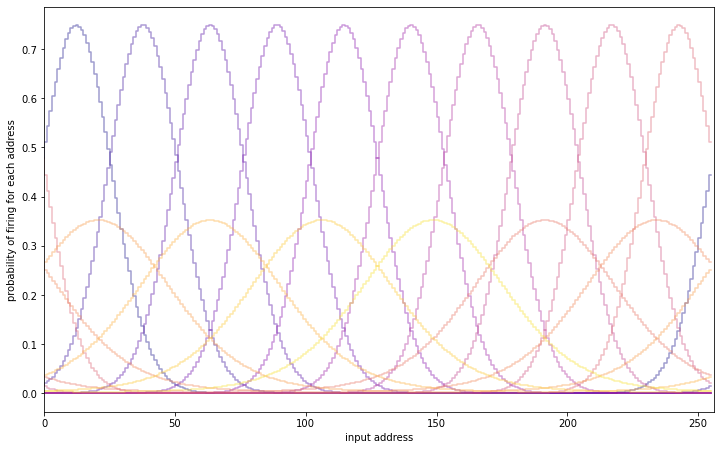

In [18]:
# ... Of Y 
if verb :
    opt = init([])
    opt.Bt_mode = 'proportion'
    d = Data(opt)
    p_true = d.stack()
    d.plot_proba(p_true)

    plt.show()

On génère des probabilités de firing pour tous nos neurones (input adress) suite à la présentation de différentes orientations. On les stocks dans stack. Ces proba représentent notre ground_truth, notre y : on veut que le réseau apprenne l'activité des neurones suite à la présentation de chaque orientation 

-> c'est quoi les courbes oranges ? 

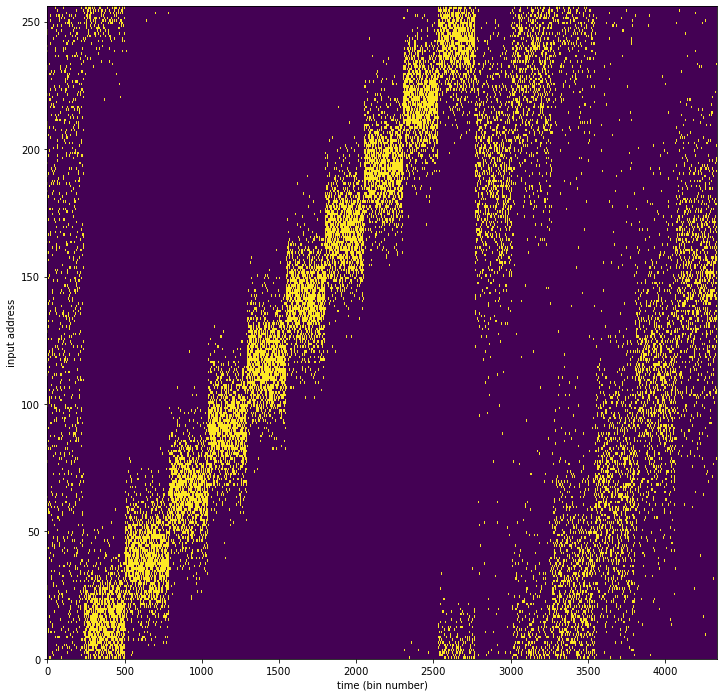

In [24]:
# ... Of X 
if verb :
    b = d.get_data(p_true, do_shuffle=False)
    d.plot_raster(b)
    plt.show()

On génère nos entrées, X. On représente l'activité de nos neurones pour chaque trial, 250 trials pour chaque orientation. Puisqu'on a ingégré les probas de firing, l'activité générée correspond à ce que l'on pourrait obtenir avec de vrais datas. 

Maintenant on va faire de la detection sur ces entrées. A partir de l'activité des neurones on va essayer de retrouver l'orientation présentée. 

## spike detection scheme


In [ ]:
class OnlineBinaryDetection(Data) :
    def __init__(self, opt) :
        super().__init__(opt)
        
    def surprise(self, b, p) :
        return -(b[:, :, None]*np.log2(p[None, :, :]) + (1-b[:, :, None])*np.log2(1-p[None, :, :])).sum(axis=1) # cual es esso ? 
    
    def firing_rate(self, b) :
        f = np.zeros_like(b*1)
        f[0, :] = self.opt.p_0 * np.ones(self.opt.N) # sur la première ligne on a la moyenne de firing rate * 1 (idkwhy)
        T, N = b.shape
        
        for t in range(T) :
            f[t, :] = self.opt.h * b[t, :] + (1 - self.opt.h) * f[t-1, :] # dans les colones on a b un peu chelou mdr, avec du hasard/variabilité
        return f # f.shape = T,N, donc f = b avec du hasard/variabilité
    
    def get_surprise(self, b, p) :
        T, N = b.shape
        N_, K = p.shape
        
        S = np.zeros((T, self.opt.K)) #S.shape = T,K
        S[-1, :] = self.surprise(self.opt.p_0 * np.ones((1, self.opt.N)), p) # sur la dernière ligne dut mets surprise*1 (idkwhy,idkwhatis surprise)
        
        for t in range(T) :
            S[t, :] = (1- self.opt.h) * S[t-1, :] + self.opt.h * self.surprise(b[t,:][None,:], p) # dans les colonnes tu mets surprise avec du hasard/variabilité
        return S
    
    def get_proba(self, S) : # soft max (mieux de faire sigm) ? 
        P = np.exp(-np.log(2) * S) 
        P /= P.sum(axis = 1)[:, None]
        return P 
    
    def get_output(self, P, N_pop = 100) :
        T,K = P.shape
        b_out = np.zeros((T,0))
        
        for k in range(K) :
            b_out_ = np.random.rand(T, N_pop) < P[:,k][:, None]
            b_out = np.hstack((b_out, b_out_.astype(float)))
            
        return b_out
    
    def plot_signal(self, signal, xlabel='time (bin number)', ylabel='signal', alpha=.4):
        fig, ax = plt.subplots(1, 1, figsize=(opt.fig_width, opt.fig_width/opt.phi))
        ax.plot(signal, alpha=alpha)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        return fig, ax
    
    def plot_surprise(self, S, alpha=.4):
        return self.plot_signal(S, ylabel='NLL', alpha=alpha)
    
    def plot_proba_out(self, P, alpha=.4):
        return self.plot_signal(P, ylabel='proba', alpha=alpha)

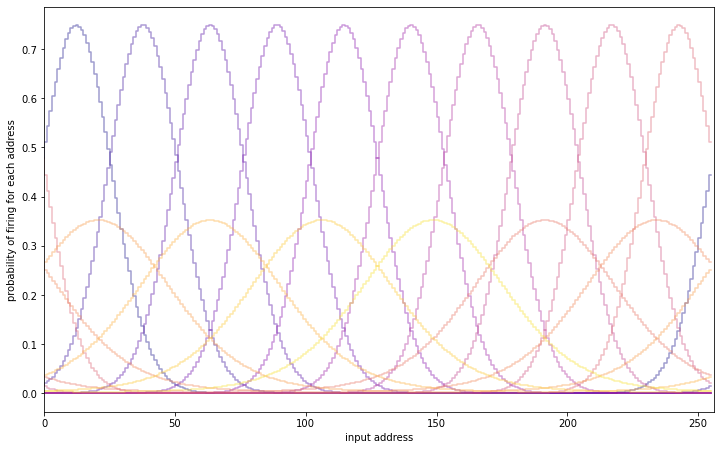

In [38]:
if verb :
    obd = OnlineBinaryDetection(opt)
    p_true = obd.stack()
    obd.plot_proba(p_true)

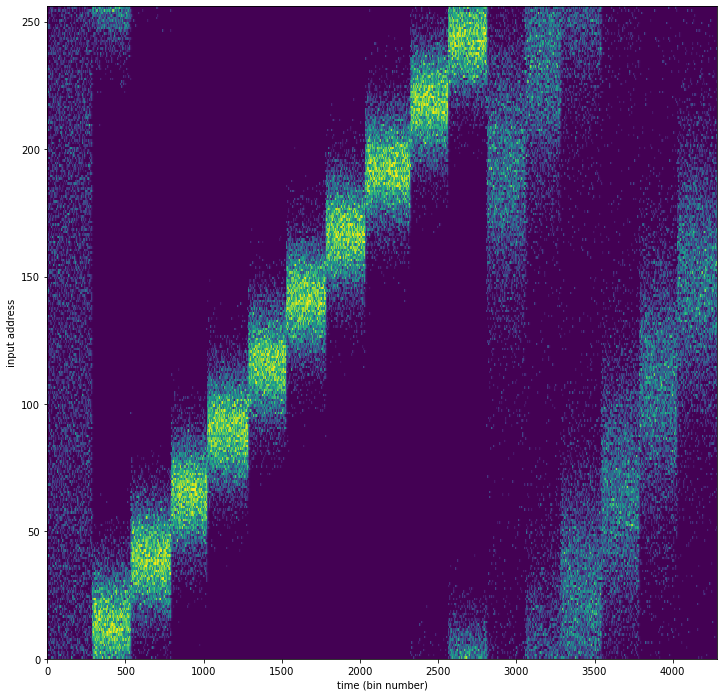

In [39]:
if verb :
    b = obd.get_data(p_true, do_shuffle=False)
    obd.plot_raster(obd.firing_rate(b))
    plt.show()

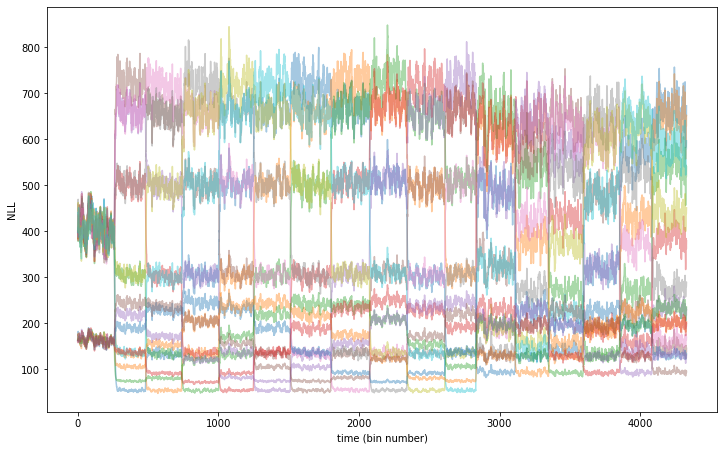

In [28]:
if verb :
    S = obd.get_surprise(b, p_true)
    obd.plot_surprise(S)

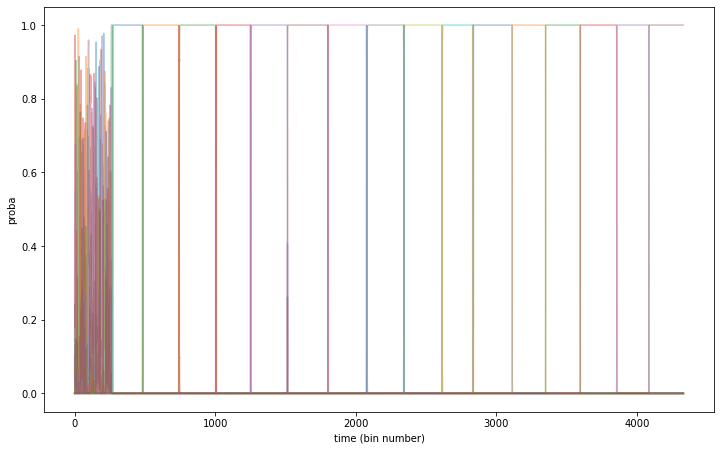

In [47]:
if verb :
    P = obd.get_proba(S)
    obd.plot_proba_out(P)

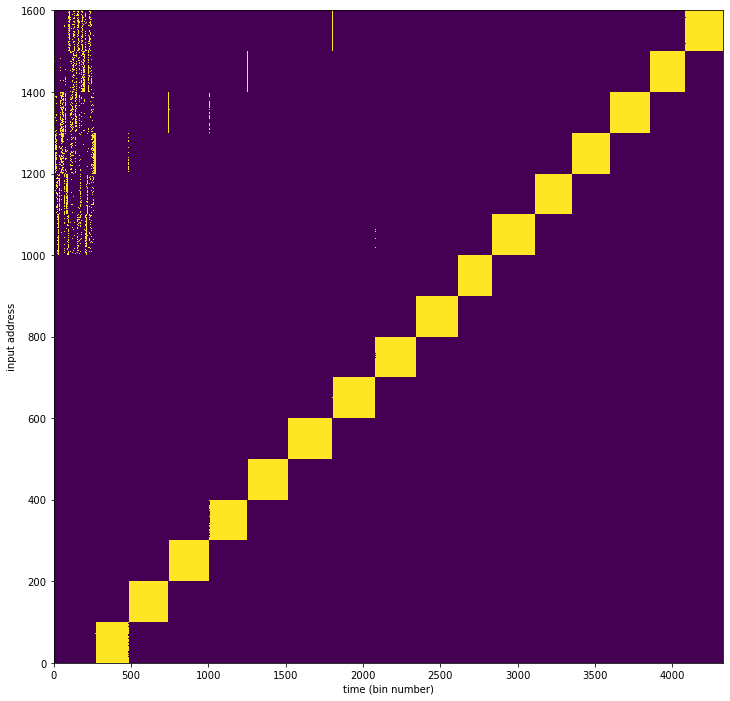

In [49]:
if verb :
    b_out = obd.get_output(P, N_pop = 100)
    obd.plot_raster(b_out)

## online clustering


In [51]:
class AdaptiveBinaryClustering(OnlineBinaryDetection) :
    def __init__(self, opt) :
        super().__init__(opt)
    
    def prior(self, noise = 1) :
        p_hat = np.ones((self.opt.N, self.opt.K)) + noise * np.random.rand(self.opt.N, self.opt.K)
        p_hat *= self.opt.p_0 / p_hat.mean()
        return p_hat
    
    def learn(self, p_true=None, b=None) :
        proba_win = np.ones((self.opt.N_epochs, self.opt.K)) / self.opt.K
        F = np.zeros(self.opt.N_epochs)
        tq = trange(self.opt.N_epochs, leave = True)
        
        p_hat = self.prior() # init au hazard
        
        for i_epoch in tq :
            proba_win[i_epoch, :] = np.zeros(self.opt.K)
            if b is None:
                b = self.get_data(p_true, do_warmup = False)
            
            T, N = b.shape
            
            # surprise = estimation de l'erreur

            #S = self.get_surprise(b, p_hat) # goal : diminuer la surprise 
            #P = self.get_proba(S)
            
            #if opt.do_fr :
            #    f = self.firing_rate(b)
                
            eta_ = self.opt.eta
            eta_T = 1/T
            
            for t in range(T) :
                # 1/ detection
                S = self.get_surprise(b[t, :], p_hat) # goal : diminuer la surprise 
                #P = self.get_proba(S)
            
                #proba = P[t, :] * np.exp(- self.opt.alpha * (proba_win[i_epoch -1, :] - 1 / self.opt.K))
                
                #k_star = P.argmax()
                k_star = S.argmin()
                
                # 2/ apprentissage
                # estimation de la probabilité, init au hasard puis modif selon surprise pour coller à ptrue 
                p_hat[:, k_star] *= 1 - eta_ 
                p_hat[:, k_star] += eta_ * b[t,:]
                
                proba_win[i_epoch, :] += eta_T * (np.arange(self.opt.K) == k_star)
                F[i_epoch] += S[t, k_star]/T
                
            tq.refresh()
            
        return p_hat, P, F, proba_win
    
    def plot_F(self, F, alpha=.4):
        fig, ax = self.plot_signal(F, xlabel='epochs', ylabel='free energy', alpha=alpha)
        #ax.plot([0, N_epochs], [F_true, F_true], '--', alpha=.4, lw=2)
        return fig, ax
    
    def plot_P_win(self, proba_win, alpha=.4):
        fig, ax = plt.subplots(1, 1, figsize=(opt.fig_width, opt.fig_width/opt.phi))
        ax.pcolormesh(np.arange(self.opt.N_epochs), np.arange(self.opt.K), proba_win.T, alpha=.9)
        ax.set_ylabel('Pr_win')
        ax.set_xlabel('epochs')
        return fig, ax

    def plot_p_hat(self, p, p_true=None, ms='-', alpha=.4):
        fig, ax = self.plot_proba(p_true, ms='--', alpha=alpha)
        cmap = plt.get_cmap("plasma")
        for k in range(self.opt.K):
            ax.step(np.arange(self.opt.N), p[:, k], ms, alpha=alpha, color=cmap(k/self.opt.K))
        return fig, ax

In [52]:
if verb :
    abc = AdaptiveBinaryClustering(opt)
    p_true = abc.stack()
    p_hat, P, F, proba_win = abc.learn(p_true)

 51%|█████     | 2077/4096 [38:26<37:21,  1.11s/it]  


KeyboardInterrupt: 

In [ ]:
if verb :
    abc.plot_F(F)

In [ ]:
if verb :
    abc.plot_P_win(proba_win)

In [ ]:
if verb :
    abc.plot_p_hat(p_hat, p_true)

In [ ]:
if verb :
    b_out = abc.get_output(P, N_pop = 100)
    abc.plot_raster(b_out)

# Exploring parameters


In [ ]:
import copy
class Scan():
    def __init__(self, opt, p_true = None):
        """
        Scanning class
        """
        #super().__init__(opt)
        self.opt = opt
        
        if p_true is None :
            self.do_data = True
        else :
            self.do_data = False
            self.p_true = p_true

    def modul(self, N_scan, base):
        return np.logspace(-1, 1, N_scan, base=base)

    def scan(self, variable='h', values=None, N_scan=24, base=4, n_jobs=-1):
        abc = AdaptiveBinaryClustering(self.opt)
        if values is None:
            values = abc.d[variable]*self.modul(N_scan=N_scan, base=base)
            if isinstance(abc.d[variable], int):
                values = [int(value) for value in values]
                values = np.unique(values)
                
        N_scan = len(values)
        
        def run(opt, variable, value):
            opt = copy.deepcopy(self.opt)
            # changing value for the variable
            abc = AdaptiveBinaryClustering(opt)
            abc.d[variable] = value

            # running the learning
            if self.do_data :
                p_true = abc.stack()
                p_hat, P, F, proba_win = abc.learn(p_true)
            else :
                p_hat, P, F, proba_win = abc.learn(self.p_true)
                
            return F[-1]   
            
        if n_jobs==1:
            F_final = np.zeros(N_scan)
            tq = trange(N_scan, desc=f'======{variable}======', leave=True)        
            for i_scan in tq:
                tq.set_description(f'={variable}={values[i_scan]}=')
                tq.refresh() # to show immediately the update
                F_final[i_scan] = run(self.opt, variable, values[i_scan])
        else:
            from joblib import Parallel, delayed
            F_final = Parallel(n_jobs=n_jobs, verbose=15*self.opt.verbose)(delayed(run)(self.opt, variable, value) for value in values)            
        
        return values, F_final

    def plot_scan(self, values, F_final, variable='h', alpha=.9):
        fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
        ax.plot(values, F_final, alpha=alpha)
        ax.set_ylabel('free energy')
        ax.set_xlabel(variable)
        ax.set_xscale('log')
        return fig, ax

In [ ]:
if verb :
    s = Scan(opt)

## exploring Bt_mode


In [ ]:
if verb :
    variable = 'Bt_mode'
    Bt_modes = ['random', 'single', 'proportion']
    for Bt_mode in Bt_modes:
        opt = init()
        # changing value for the variable
        abc = AdaptiveBinaryClustering(opt)
        abc.d[variable] = Bt_mode
        print(f'{variable} = {abc.d[variable]}')

        # running the learning
        p_true = abc.stack()
        p_hat, P, F, proba_win = abc.learn(p_true)

        abc.plot_F(F)
        abc.plot_P_win(proba_win)
        abc.plot_p_hat(p_hat, p_true)
        plt.show()


## explore binary variables

In [ ]:
if verb :
    for variable in ['do_pi', 'do_fr']:
        opt = init()
        # changing value for the variable
        abc = AdaptiveBinaryClustering(opt)
        abc.d[variable] = not abc.d[variable]
        print(f'{variable} = {abc.d[variable]}')

        # running the learning
        p_true = abc.stack()
        p_hat, P, F, proba_win = abc.learn(p_true)

        abc.plot_F(F)
        abc.plot_P_win(proba_win)
        abc.plot_p_hat(p_hat, p_true)
        plt.show()    

## explore scalar variables

In [ ]:
if verb :
    for variable in ['h', 'eta', 'alpha', 'B_theta', 'p_0']:
        values, F_final = s.scan(variable)
        s.plot_scan(values, F_final, variable=variable)
        plt.show()

## exploring dimensions


In [ ]:
if verb :
    for variable in ['N_epochs', 'N', 'K', 'N_trials', ]:
        values, F_final = s.scan(variable)
        s.plot_scan(values, F_final, variable=variable)
        plt.show()